In [ ]:
#%pip install gym

#importing dependencies
from gym import Env
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col

# Building a dangerous gridworld

In [ ]:
#this class defines a 2D coordinate system
class Coordinate(object):
  def __init__(self, x, y, is_dangerous):
    #changing x will move vertically and y will move horizontally
    self.x = x
    self.y = y
    self.danger = is_dangerous
  def __str__(self):
    return "({}, {}, {})".format(self.x, self.y, self.danger)

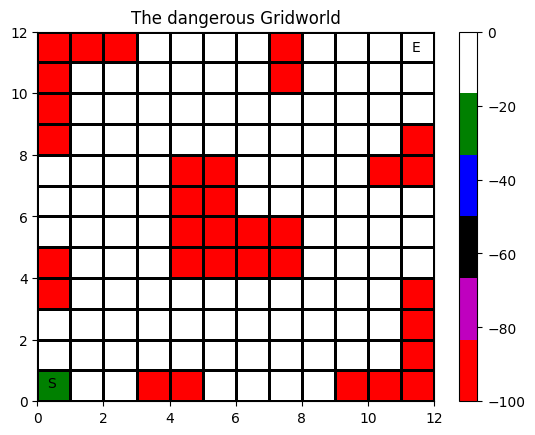

In [ ]:
#We need extend the functionalities of the Env class (the superclass here is the env class)
#This is the environment class: where our agent will learn.
class dangerous_gridWorld(Env):
  #override the the following, in the Env class
  def __init__(self, grid_specs=[12,12], start_state=[0, 0], end_state=[11, 11], danger_states = [[False, False, False, True, True, False, False, False, False, True, True, True],
                                                                                                  [False, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [False, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [True, False, False, False, True, True, True, True, False, False, False, False],
                                                                                                  [False, False, False, False, True, True, True, True, False, False, False, False],
                                                                                                  [False, False, False, False, True, True, False, False, False, False, False, False],
                                                                                                  [False, False, False, False, True, True,  False, False, False, False, True, True],
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, False],
                                                                                                  [True, False, False, False, False, False, False, True, False, False, False, False],
                                                                                                  [True, True, True, False, False, False, False, True, False, False, False, False]]):

    #initialize out setting, state space, action and rewards
    self.grid_specs = grid_specs
    #Dynamics of the MDP
    #action space
    self.actions =  ['left', 'up', 'right', 'down']
    #state space (defines the shape of the gridworld)
    #the states in itself has the knowledge of whether it is dangerous
    self.states = [[Coordinate(i, j, danger_states[i][j]) for j in range(grid_specs[1])] for i in range(grid_specs[0])]
    #for a SSPP
    self.start_state = Coordinate(start_state[0], start_state[1], False)
    self.end_state = Coordinate(end_state[0], end_state[1], False)

    #since the transition probabilities are deterministic
    #(i.e.: next state and reward is determinitic and hence we don't need to define it)

  def get_D_i(self):
    D_i = np.zeros(shape=self.grid_specs, dtype=bool)
    for i in range(self.grid_specs[0]):
      for j in range(self.grid_specs[1]):
        if (self.states[i][j].danger==True):
          D_i[i][j] = True
        elif i==0 or j==0:
          if i==0 and (j<self.grid_specs[1]-1 and self.states[i][j+1].danger == True) or (j-1>0 and self.states[i][j-1].danger == True):
            D_i[i][j] = True
          elif j==0 and (i<self.grid_specs[0]-1 and self.states[i+1][j].danger == True) or (i-1>0 and self.states[i-1][j].danger == True):
            D_i[i][j] = True
          else:
            D_i[i][j] = False
        elif i==self.grid_specs[0]-1 or j==self.grid_specs[1]-1:
          if i==self.grid_specs[0]-1 and (j<self.grid_specs[1]-1 and self.states[i][j+1].danger == True) or (j-1>0 and self.states[i][j-1].danger == True):
            D_i[i][j] = True
          elif j==self.grid_specs[1]-1 and (i<self.grid_specs[0]-1 and self.states[i+1][j].danger == True) or (i-1>0 and self.states[i-1][j].danger == True):
            D_i[i][j] = True
          else:
            D_i[i][j] = False
        elif (self.states[i+1][j].danger == True or self.states[i-1][j].danger == True) or (self.states[i][j+1].danger == True or self.states[i][j-1].danger ==True):
          D_i[i][j] = True
    return D_i

  def step(self, state, action):
    #current state is of Coordinate type and action is a single string

    #define the dynamics of a single step
    #(0,0) is the start state and (7, 7) is the terminal state
    #Going outside the grid incurs a penalty of -5 and entering the dangerous states makes the penalty be as high as -20 (hoping teacher can save the day)
    #x axis and y axis are inverted here
    next_state = None
    #flag_out = False
    reward = -1
    if action == 'left':
      if state.y - 1 < 0:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #flag_out = True
      else:
        next_state = self.states[state.x][state.y-1]

    elif action == "up":
      if state.x + 1 > self.end_state.x:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #went out of the grid
      else:
        next_state = self.states[state.x+1][state.y]

    elif action == "right":
      if state.y + 1 > self.end_state.y:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #went out of the grid
      else:
        next_state = self.states[state.x][state.y+1]
        #if the next state is a danger state: then a reward of -20 will be encountered

    elif action == "down":
      if state.x - 1 < 0:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #flag_out = True
      else:
        next_state = self.states[state.x-1][state.y]
        #if the next state is a danger state: then a reward of -20 will be encountered
    else:
      print("Invalid Action")
      next_state = state
      reward = 0

    #if flag_out== True:
    #  reward = -20
    #if the next state is a danger state: then a reward of -20 will be encountered
    if self.states[next_state.x][next_state.y].danger == True:
      reward = -100

    done = False
    if next_state.x == self.end_state.x and next_state.y == self.end_state.y:
      done = True
    #an empty dictionary needs to be returned as prescribed by the documents. This is used for returning any extra information
    info = {}
    return next_state, reward, done, info

  def render(self, current_state, title=""):
    #render graphics for the environment
    mesh_gd = np.zeros((self.end_state.x+1, self.end_state.y+1))
    for i in range(mesh_gd.shape[0]):
      for j in range(mesh_gd.shape[1]):
        if self.states[i][j].danger == True:
          mesh_gd[i][j] = -100
        else:
          mesh_gd[i][j] = 0
    mesh_gd[current_state.x][current_state.y] = -20
    plt.pcolormesh(mesh_gd, edgecolors='black', linewidth=2, cmap = col.ListedColormap(['r', 'm', 'k', 'b', 'g', 'w']))
    plt.colorbar()
    #adjusting text according to the relative positioning
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The dangerous Gridworld"+title)

  def disp2(self, dang_states):
    mesh_gd = np.zeros((self.end_state.x+1, self.end_state.y+1))
    for i in range(mesh_gd.shape[0]):
      for j in range(mesh_gd.shape[1]):
        if self.states[i][j].danger == True:
          mesh_gd[i][j] = -100
        elif dang_states[i][j] == True:
          mesh_gd[i][j] = -40
        else:
          mesh_gd[i][j] = 0

    plt.pcolormesh(mesh_gd, edgecolors='black', linewidth=2, cmap = col.ListedColormap(['r', 'y', 'w']))
    plt.colorbar()
    #adjusting text according to the relative positioning
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The teacher's knowledge of the grid world")

  def reset(self):
    #reset at the end of an episode
    return self.start_state

  def is_terminal(self, state):
    if state.x == self.end_state.x and state.y == self.end_state.y:
      return True
    return False

  def __str__(self):
    print("states: ")
    for i in range(self.grid_specs[0]):
      for j in range(self.grid_specs[1]):
        print(self.states[i][j])
    print('Start State: {}'.format(self.start_state))
    print('End State: {}'.format(self.end_state))
    return "actions: {}".format(self.actions)

gw = dangerous_gridWorld()
#gw.render(Coordinate(0, 0, True))
gw.render(gw.start_state)
#gw.render(gw.end_state)
#n_state, reward = gw.step(gw.states[1][2], "down")
#print(n_state, reward)

# Value Iteration
Start with $ V_0 = 0$
$$\large v_{k+1}(s) = \text{max}_a\sum_{s', r} p(s', r | s, a)[r + \gamma v_k(s')]$$
 Update $\pi_{n+1}$ accordingly as best action 

Obtain $V_{\pi_*}$ till the updates converge

In [ ]:
class ValueIterationAgent:
    def __init__(self, env, gamma=0.9, epsilon=1e-9):
        self.env = env
        self.gamma = gamma
        self.epsilon=epsilon
        self.V = np.zeros(env.grid_specs)
        self.policy = np.full(env.grid_specs, '', dtype=object)

    def run_value_iteration(self):
        while True:
            delta = 0
            for i in range(self.env.grid_specs[0]):
                for j in range(self.env.grid_specs[1]):
                    state = self.env.states[i][j]
                    if self.env.is_terminal(state):
                        continue
                    max_value = float('-inf')
                    best_action = None
                    for action in self.env.actions:
                        next_state, reward, _, _ = self.env.step(state, action)
                        v = reward + self.gamma * self.V[next_state.x][next_state.y]
                        if v > max_value:
                            max_value = v
                            best_action = action   
                    delta = max(delta, abs(self.V[i][j] - max_value))
                    self.V[i][j] = max_value
                    self.policy[i][j] = best_action
            if delta < self.epsilon:
                break

    def print_value_function(self):
        plt.pcolormesh(self.V, edgecolors='grey')
        plt.figtext(0.71, 0.84, "E")
        plt.figtext(0.14, 0.14, "S")
        plt.title("The Value function of dangerous Gridworld")
        plt.colorbar()
        plt.show()

    def print_policy(self):
        env = self.env
        env.render(env.states[0][0], ": The Optimal Policy")
        for i in range(env.grid_specs[0]):
            for j in range(env.grid_specs[1]):
                plt.scatter(i+0.5, j+0.5, color='black')
                action = self.policy[i][j]
                if action == 'left':
                    plt.quiver(j+0.5, i+0.5, -0.4, 0, color='black')
                elif action == 'up':
                    plt.quiver(j+0.5, i+0.5, 0, 0.4, color='black')
                elif action == 'right':
                    plt.quiver(j+0.5, i+0.5, 0.4, 0, color='black')
                elif action == 'down':
                    plt.quiver(j+0.5, i+0.5, 0, -0.4, color='black')
        plt.show()

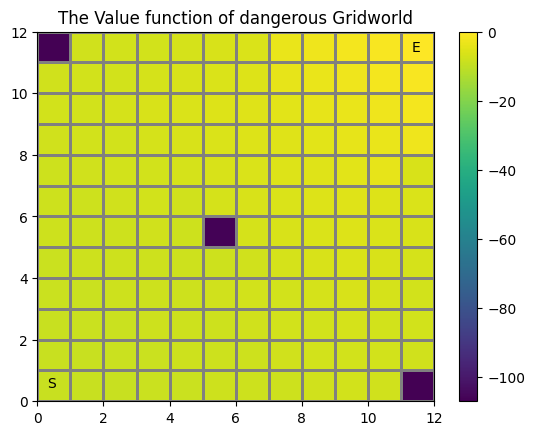

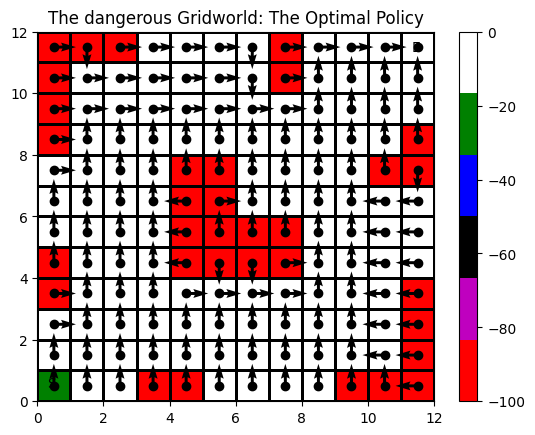

In [ ]:
obj =ValueIterationAgent(gw)
obj.run_value_iteration()
obj.print_value_function()
obj.print_policy()